In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from utils import fft_denoiser, split_function, multiple_gmm,ModLSTM,accuracy_fn,Autoencoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch
from torch.nn import LSTM
from sklearn.decomposition import PCA,KernelPCA

## LSTM for Trading Signal on SP500  ##



The LSTM will use the following data:
- Log Daily Returns in Percentage
- VIX divided into 3 categories (Low,Medium,High)
- Interest Rate at 3mo,6mo,1y
- Inflation Rate
- CPI
- Per Share Earnings
- Unemployment Rate
- NFP

The categorical Features will be 1 hot encoded resulting with a dataframe with a lot of features. For this reason there were applied dimensionality reduction techniques.

### Preprocess

In [2]:
data = yf.download(tickers="^GSPC", period="max")
df  = pd.DataFrame(data)
df.columns = df.columns.get_level_values('Price')

[*********************100%***********************]  1 of 1 completed


In [3]:
df['yClose'] = df['Close'].shift(1)
df['daily_returns_pct'] = (df['Close']-df['yClose'])/df['Open'] * 100
df['log_daily_returns_pct'] = np.log(df['Close']/df['yClose']) * 100

df = df.round(2)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df

Price,Close,High,Low,Open,Volume,yClose,daily_returns_pct,log_daily_returns_pct
Date,,,,,,,,
1927-12-30,17.66,17.66,17.66,17.66,0,NaN,NaN,NaN
1928-01-03,17.76,17.76,17.76,17.76,0,17.66,0.56,0.56
1928-01-04,17.72,17.72,17.72,17.72,0,17.76,-0.23,-0.23
1928-01-05,17.55,17.55,17.55,17.55,0,17.72,-0.97,-0.96
1928-01-06,17.66,17.66,17.66,17.66,0,17.55,0.62,0.62
...,...,...,...,...,...,...,...,...
2025-01-17,5996.66,6014.96,5978.44,5995.40,4366830000,5937.34,0.99,0.99
2025-01-21,6049.24,6051.51,6006.88,6014.12,4702920000,5996.66,0.87,0.87
2025-01-22,6086.37,6100.81,6076.13,6081.39,4323040000,6049.24,0.61,0.61


In [4]:
vix_data = yf.download(tickers="^VIX", period="max")
vix  = pd.DataFrame(vix_data)
vix.columns = vix.columns.get_level_values('Price')
vix['yClose'] = vix['Close'].shift(1)

[*********************100%***********************]  1 of 1 completed


In [5]:
vix.drop(['Close','High','Low','Open','Volume'],axis = 1,inplace=True)

In [6]:
def vix_assign(value):
    if (value<=15):
        return 'low_vol'
    elif (value<=25):
        return 'medium_vol'
    elif (value<=30):
        return 'high_vol'
    else:
        return 'extreme_vol'
vix.dropna(inplace=True)
vix['result'] = vix['yClose'].apply(vix_assign)

In [7]:
vix = pd.get_dummies(vix,columns=['result'])

In [8]:
cat = ['result_low_vol','result_medium_vol','result_high_vol','result_extreme_vol']
for el in cat:
    vix[el] = vix[el].replace({True: 1, False: 0})

/var/folders/r1/yrqdcrd10lxb181crqq08nhr0000gn/T/ipykernel_44365/4115979425.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vix[el] = vix[el].replace({True: 1, False: 0})


In [9]:
vix.drop('yClose',axis=1,inplace=True)
vix

,result_extreme_vol,result_high_vol,result_low_vol,result_medium_vol
Date,,,,
1990-01-03,0,0,0,1
1990-01-04,0,0,0,1
1990-01-05,0,0,0,1
1990-01-08,0,0,0,1
1990-01-09,0,0,0,1
...,...,...,...,...
2025-01-17,0,0,0,1
2025-01-21,0,0,0,1
2025-01-22,0,0,0,1


In [10]:
#Da reversare ed aggiustare le date
interest = pd.read_csv("data/yield-curve-rates-1990-2023.csv")
interest['Date'] = pd.to_datetime(interest['Date'])
interest.set_index('Date', inplace=True)
interest.sort_index(inplace=True)
interest = interest[['3 Mo','6 Mo','1 Yr']]
interest

/var/folders/r1/yrqdcrd10lxb181crqq08nhr0000gn/T/ipykernel_44365/3354881613.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  interest['Date'] = pd.to_datetime(interest['Date'])


,3 Mo,6 Mo,1 Yr
Date,,,
1990-01-02,7.83,7.89,7.81
1990-01-03,7.89,7.94,7.85
1990-01-04,7.84,7.90,7.82
1990-01-05,7.79,7.85,7.79
1990-01-08,7.79,7.88,7.81
...,...,...,...
2023-12-22,5.44,5.31,4.82
2023-12-26,5.45,5.28,4.83
2023-12-27,5.44,5.26,4.79


In [11]:
inflation = pd.read_csv("data/US_inflation_rates.csv")
inflation['Date'] = pd.to_datetime(inflation['date'])
inflation.set_index('Date', inplace=True)
inflation.drop('date', axis=1, inplace=True)
inflation.sort_index(inplace=True)
inflation = inflation.rename(columns={'value':'inflation_value'})
inflation

,inflation_value
Date,
1947-01-01,21.480
1947-02-01,21.620
1947-03-01,22.000
1947-04-01,22.000
1947-05-01,21.950
...,...
2023-02-01,301.648
2023-03-01,301.808
2023-04-01,302.918


In [12]:
unrate = pd.read_csv("data/UNRATE.csv")
unrate['Date'] = pd.to_datetime(unrate['observation_date'])
unrate.drop('observation_date', axis=1, inplace=True)
unrate.set_index('Date', inplace=True)
unrate

,UNRATE
Date,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2024-07-01,4.3
2024-08-01,4.2
2024-09-01,4.1


In [13]:
pe_cpi = pd.read_csv("flat-ui__data-ThuJan022025.csv")
pe_cpi = pe_cpi[['Date','Consumer Price Index','PE10']]
pe_cpi = pe_cpi.rename(columns={'PE10':'PE'})
pe_cpi['Date'] = pd.to_datetime(pe_cpi.Date)
pe_cpi.set_index('Date', inplace=True)
pe_cpi = pe_cpi.sort_index()
pe_cpi

,Consumer Price Index,PE
Date,,
1871-01-01,12.37,0.00
1871-01-01,12.46,0.00
1871-02-01,12.84,0.00
1871-03-01,13.03,0.00
1871-04-01,12.56,0.00
...,...,...
2023-05-01,304.13,31.14
2023-06-01,305.11,32.41
2023-07-01,305.69,33.38


In [14]:
nfp = pd.read_csv("data/PAYEMS.csv")
nfp['last_month'] = nfp['PAYEMS'].shift(1)
nfp['pct_change'] = np.round(((nfp['PAYEMS'] - nfp['last_month'])/nfp['PAYEMS']) * 100,2)
nfp['positive_nfp'] = nfp.apply(lambda x: 1 if (x['PAYEMS'] - x['last_month'] > 0) else 0, axis=1)
nfp['negative_nfp'] = nfp.apply(lambda x: 1 if (x['PAYEMS'] - x['last_month'] <= 0) else 0, axis=1)
nfp['Date'] = pd.to_datetime(nfp['observation_date'])
nfp.set_index('Date', inplace=True)
nfp.drop('observation_date', axis=1, inplace=True)
nfp.sort_index(inplace=True)
nfp

,PAYEMS,last_month,pct_change,positive_nfp,negative_nfp
Date,,,,,
1939-01-01,29923,NaN,NaN,0,0
1939-02-01,30100,29923.0,0.59,1,0
1939-03-01,30280,30100.0,0.59,1,0
1939-04-01,30094,30280.0,-0.62,0,1
1939-05-01,30299,30094.0,0.68,1,0
...,...,...,...,...,...
2024-07-01,158692,158548.0,0.09,1,0
2024-08-01,158770,158692.0,0.05,1,0
2024-09-01,159025,158770.0,0.16,1,0


Esplorazione NanValue e duplicates

In [15]:
#DataFrame: df,nfp,pe_cpi,unrate,inflation,interest
df[df['daily_returns_pct'].isna()]  = 0
df[df['log_daily_returns_pct'].isna()] = 0
nfp.dropna(inplace=True) #Old data that can be deleted
interest.ffill(inplace=True) #ffil to copy the rate until the next rate cut or rate rise

Unione dei Dataframe

In [16]:
# Lista di dataframe da unire
dataframes = [nfp,vix, pe_cpi, unrate, inflation, interest]

# Merge automatizzato
result = df.copy()
for data in dataframes:
    result = result.merge(data, how='left', left_index=True, right_index=True)

#ffil since i have monthly data while the prices are daily
result.ffill(inplace=True)
result.dropna(inplace=True)

In [17]:
result.drop(['High','Low','Open','Volume','PAYEMS','last_month'],axis = 1,inplace = True)

### Splitting ed Normalization

In [18]:
#Utilizziamo la fft per ridurre il rumore del prezzo close
result['Close'] = np.round(fft_denoiser(result['Close'],0.001,True),2)
result['future_close'] = result['Close'].shift(-1)
result['Prediction'] = result.apply(lambda x: 1 if x['future_close'] > x['Close'] else 0 ,axis = 1) #Ground Truth


In [19]:
result.drop(['future_close','yClose',], axis = 1, inplace = True)

In [20]:
result

,Close,daily_returns_pct,log_daily_returns_pct,pct_change,positive_nfp,negative_nfp,result_extreme_vol,result_high_vol,result_low_vol,result_medium_vol,Consumer Price Index,PE,UNRATE,inflation_value,3 Mo,6 Mo,1 Yr,Prediction
Date,,,,,,,,,,,,,,,,,,
1990-01-03,2831.78,-0.26,-0.26,0.08,1.0,0.0,0.0,0.0,0.0,1.0,126.10,21.15,5.4,126.300,7.89,7.94,7.85,0
1990-01-04,2080.60,-0.86,-0.87,0.08,1.0,0.0,0.0,0.0,0.0,1.0,126.10,21.15,5.4,126.300,7.84,7.90,7.82,0
1990-01-05,1405.88,-0.98,-0.98,0.08,1.0,0.0,0.0,0.0,0.0,1.0,126.10,21.15,5.4,126.300,7.79,7.85,7.79,0
1990-01-08,848.08,0.45,0.45,0.08,1.0,0.0,0.0,0.0,0.0,1.0,126.10,21.15,5.4,126.300,7.79,7.88,7.81,0
1990-01-09,430.49,-1.18,-1.19,0.08,1.0,0.0,0.0,0.0,0.0,1.0,126.10,21.15,5.4,126.300,7.80,7.82,7.78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-17,5929.39,0.99,0.99,0.14,1.0,0.0,0.0,0.0,0.0,1.0,306.13,33.25,4.2,303.841,5.40,5.26,4.79,0
2025-01-21,5541.45,0.87,0.87,0.14,1.0,0.0,0.0,0.0,0.0,1.0,306.13,33.25,4.2,303.841,5.40,5.26,4.79,0
2025-01-22,5007.61,0.61,0.61,0.14,1.0,0.0,0.0,0.0,0.0,1.0,306.13,33.25,4.2,303.841,5.40,5.26,4.79,0


# Only LSTM

In [21]:
result.var()

Close                    1.592325e+06
daily_returns_pct        1.291778e+00
log_daily_returns_pct    1.293012e+00
pct_change               6.615262e-01
positive_nfp             1.552546e-01
negative_nfp             1.552546e-01
result_extreme_vol       7.489215e-02
result_high_vol          8.644812e-02
result_low_vol           2.215000e-01
result_medium_vol        2.499609e-01
Consumer Price Index     2.348454e+03
PE                       4.451514e+01
UNRATE                   3.064476e+00
inflation_value          2.327077e+03
3 Mo                     5.321673e+00
6 Mo                     5.417177e+00
1 Yr                     5.305800e+00
Prediction               2.493704e-01
dtype: float64

In [49]:
selected_features = ['Close', 'daily_returns_pct', 'log_daily_returns_pct', 'pct_change',
       'positive_nfp', 'negative_nfp','result_extreme_vol','result_high_vol','result_low_vol','result_medium_vol', 'Consumer Price Index', 'PE', 'UNRATE',
       'inflation_value', '3 Mo', '6 Mo', '1 Yr']
X_train,y_train,X_test,y_test = split_function(result,selected_features,'Prediction',type="classic")
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

standard = StandardScaler()
X_train = standard.fit_transform(X_train)
X_test = standard.transform(X_test)

## Classic PCA

In [23]:
pca = PCA()
pca.fit(X_train) #Conserva tutte le component, per ispezione andiamo a cercare quelle che conservano almeno il 90% della var
explained_variance = pca.explained_variance_ratio_
cum_variance = np.cumsum(pca.explained_variance_ratio_)
idx = np.arange(len(selected_features))+1 #Creo un vettore con n components, mi servirà per il successivo plt

print_variance = pd.DataFrame([explained_variance,cum_variance],index=['Exp Var','Cum Var'],columns=idx).T
mean_variance = print_variance.iloc[:,0].mean()
print(print_variance)


         Exp Var   Cum Var
1   2.479095e-01  0.247909
2   1.982528e-01  0.446162
3   1.178067e-01  0.563969
4   1.145099e-01  0.678479
5   9.080504e-02  0.769284
6   6.841193e-02  0.837696
7   5.465017e-02  0.892346
8   4.909123e-02  0.941437
9   3.825864e-02  0.979696
10  1.688596e-02  0.996582
11  2.994430e-03  0.999576
12  3.924851e-04  0.999969
13  1.913236e-05  0.999988
14  6.842017e-06  0.999995
15  5.300953e-06  1.000000
16  3.432599e-16  1.000000
17  2.373206e-17  1.000000


Con sole 5 component andiamo a spiegare il 90% della varianza => Abbiamo dimezzato il numero di features
Possiamo anche fermarci a 4 cioè i component che sopra la media


### Plot dei Risultati

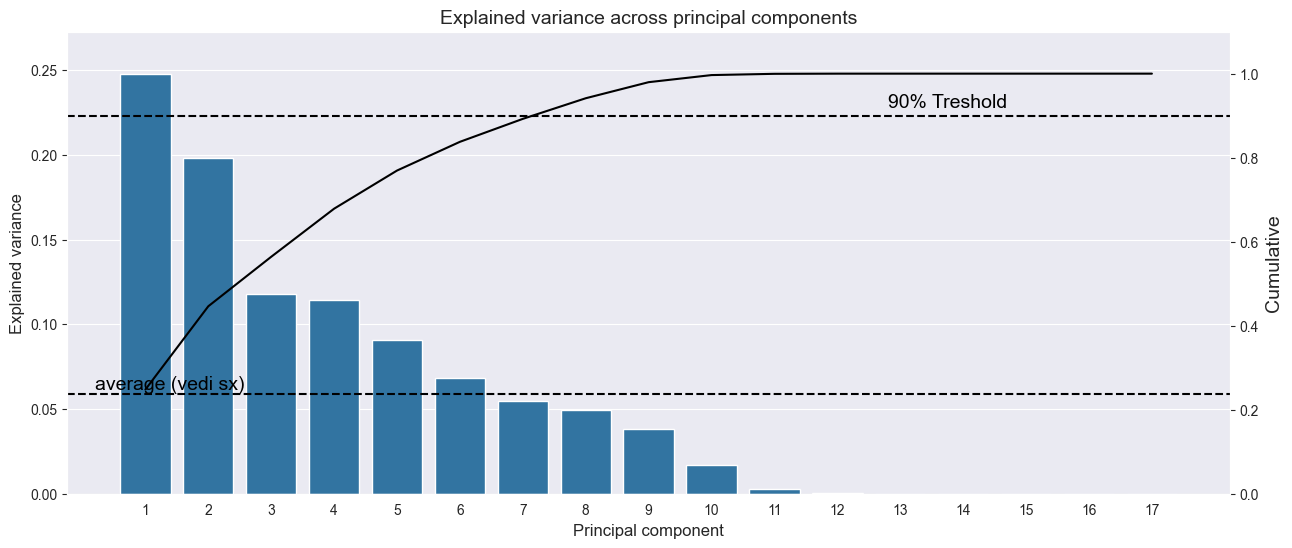

In [24]:
#Scree Plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
custom_palette = sns.color_palette(["#0000FF", "#1E90FF", "#00BFFF", "#4169E1", "#4682B4"])
ax2 = sns.barplot(x=idx, y='Exp Var', data=print_variance,legend=False)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx-1, y='Cum Var', data=print_variance, color='#000000')
ax1.axhline(mean_variance, ls='--', color='#000000') #plot mean
ax2.axhline(0.90, ls='--', color='#000000') #plot 90%
ax1.text(-.8, mean_variance+(mean_variance*.05), "average (vedi sx)", color='#000000', fontsize=14) #label y axis
ax2.text(11.8, 0.92, "90% Treshold", color='#000000', fontsize=14)
max_y1 = max(print_variance.iloc[:,0])
max_y2 = max(print_variance.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))
plt.show()

La media spiegata dai componenti è: 0.059


Text(0.06176470588235293, 5.56729294137078, 'Media: 0.06%')

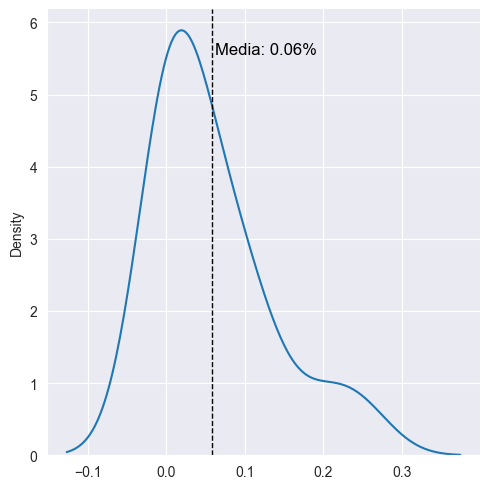

In [25]:
sns.displot(data=pca.explained_variance_ratio_,kind='kde')
print(f"La media spiegata dai componenti è: {mean_variance:.3f}")
plt.axvline(x=mean_variance, color='#000000', linestyle='--', linewidth=1, label=f'Mean = {mean_variance:.2f}')
plt.text(mean_variance+(mean_variance*.05), plt.gca().get_ylim()[1] * 0.9,  # Spostamento in x e y
         f'Media: {mean_variance:.2f}%', color='#000000', fontsize=12)

### Calcolo del projection error

L'average projection error per la PCA classica sui dati di train: 
[0.07 0.   0.   0.02 0.01 0.01 0.01 0.04 0.04 0.   0.04 0.34 0.25 0.04
 0.04 0.04 0.03]
 ,in termini percentuali, per dati di train: 
[ 7.    0.    0.    2.    1.    1.    1.    4.02  4.    0.    4.   34.
 25.03  4.    4.    4.    3.  ] con media:5.77,
le performance su dati di test si discostano mediamente del: 0.17


Text(6.0560294117647056, 0.05897619958997457, 'Media: 5.77%')

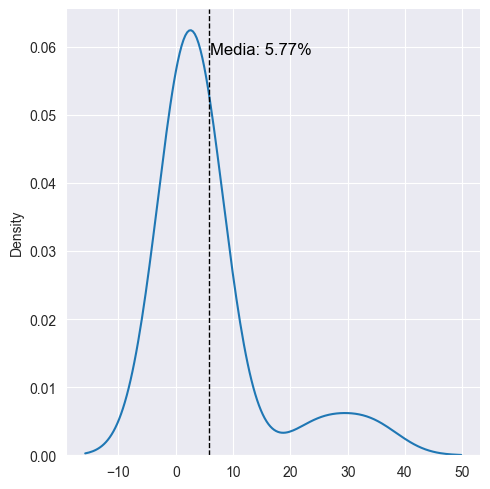

In [26]:
#Sfruttando i dati di Train
data_reduced_train = np.dot(X_train, pca.components_[:8].T)
data_original = np.dot(data_reduced_train,pca.components_[:8])

#Avg projection error
m = len(X_train)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_train[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_train[i]))**2,2)
avg_proj_error_train = np.round(diff/m,2)
avg_proj_error_train_pct = np.round((avg_proj_error_train/(original_el/m)) * 100,2)
mean_apep_train = np.mean(avg_proj_error_train_pct)

#Sfruttando i dati di test
data_reduced_test = np.dot(X_test, pca.components_[:8].T)
data_original = np.dot(data_reduced_test,pca.components_[:8])

m = len(X_test)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_test[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_test[i]))**2,2)
avg_proj_error_test = np.round(diff/m,2)
avg_proj_error_test_pct = np.round((avg_proj_error_test/(original_el/m)) * 100,2)
mean_apep_test = np.mean(avg_proj_error_test_pct)

print(f"L'average projection error per la PCA classica sui dati di train: \n{avg_proj_error_train}\n "
      f",in termini percentuali, per dati di train: \n{avg_proj_error_train_pct} con media:{np.round(mean_apep_train,2)},\n"
      f"le performance su dati di test si discostano mediamente del: {np.round( mean_apep_train - mean_apep_test,2)}")
sns.displot(avg_proj_error_train_pct,kind='kde')
plt.axvline(x=mean_apep_train, color='#000000', linestyle='--', linewidth=1, label=f'Mean = {mean_apep_train:.2f}')
plt.text(mean_apep_train+(mean_apep_train*.05), plt.gca().get_ylim()[1] * 0.9,  # Spostamento in x e y
         f'Media: {mean_apep_train:.2f}%', color='#000000', fontsize=12)

Il projection error portà con se un errore minimo sui dati di train mentre 2 features in particolare porta con sè un projection error più alto

<Axes: >

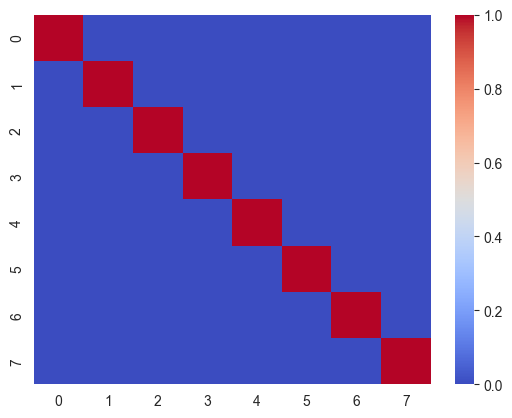

In [27]:
pca = PCA(n_components=8)
data_pca = pca.fit_transform(X_train)
correlation_matrix = np.corrcoef(data_pca.T)

sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")

Addestramento della rete

In [28]:
device = 'cpu'
X_train = torch.from_numpy(data_reduced_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(data_reduced_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [29]:
#Model Param
hidden_size = 128
input_size = 8
#Inizializziamo il modello, ricorda di runnare prima la cella della rete
model = ModLSTM(input_size=input_size,hidden_size=hidden_size,seq_lenght=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_loss = [] #per Mostrare la loss del modello

In [26]:
t0_pca = time.time()
for epoch in range(epochs):
    model.train() #Avviso il modello che è in fase di training
    output = model(X_train)
    loss = criterion(output, y_train) #Perchè lstm ci restituisce pure i pesi ma non ce ne facciamo niente
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Valutazione
    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_loss = criterion(test_out, y_test)

        predicted_classes = torch.argmax(test_out, dim=-1)
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=predicted_classes)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f} con Accuracy: {test_acc:.2f}")
t1_pca = time.time()
print(t1_pca-t0_pca)

Epoch: 9 | Loss: 0.69141| Test loss: 0.69072 con Accuracy: 52.97
Epoch: 19 | Loss: 0.68970| Test loss: 0.68939 con Accuracy: 53.03
Epoch: 29 | Loss: 0.68485| Test loss: 0.68537 con Accuracy: 53.59
Epoch: 39 | Loss: 0.67613| Test loss: 0.67793 con Accuracy: 57.05
Epoch: 49 | Loss: 0.67143| Test loss: 0.67762 con Accuracy: 56.99
78.1842429637909


In [31]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/model_pca_optimal_config.pth"
torch.save(model.state_dict(), PATH)

In [31]:
model.eval()
model.load_state_dict(torch.load('/Users/francescodesiderato/repos/QuantMath/Model/model_pca_optimal_config.pth'))

/var/folders/r1/yrqdcrd10lxb181crqq08nhr0000gn/T/ipykernel_44019/157497100.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/franc

<All keys matched successfully>

tensor([1, 0, 0,  ..., 1, 0, 0])
              precision    recall  f1-score   support

           0       0.57      0.48      0.52       850
           1       0.58      0.67      0.62       917

    accuracy                           0.58      1767
   macro avg       0.58      0.57      0.57      1767
weighted avg       0.58      0.58      0.57      1767



<Axes: >

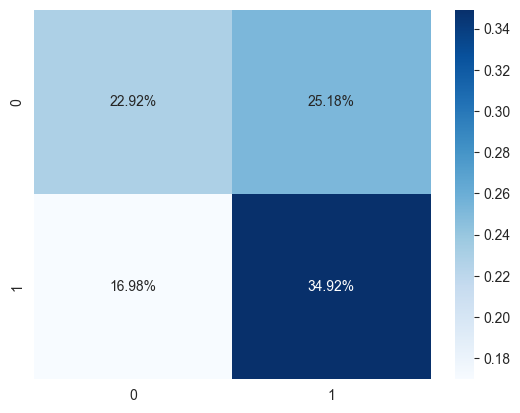

In [37]:
predicted_classes = model(X_test)
predicted_classes = torch.argmax(predicted_classes, dim=-1)
print(predicted_classes)
preds = predicted_classes.cpu().numpy()
y_true = y_test.cpu().numpy()
report = classification_report(y_true, preds)
print(report)
matrix = confusion_matrix(y_true, preds)
sns.heatmap(matrix/np.sum(matrix), annot=True,
            fmt='.2%', cmap='Blues')

## Kernel PCA

In [32]:
kpca = KernelPCA(n_components=17,kernel='poly')
kpca.fit(X_train) #Conserva tutte le component, per ispezione andiamo a cercare quelle che conservano almeno il 90% della var
kpca_transform = kpca.transform(X_train)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cum_variance = np.cumsum(explained_variance_ratio)
idx = np.arange(len(selected_features))+1 #Creo un vettore con n components, mi servirà per il successivo plt

print_variance = pd.DataFrame([explained_variance_ratio,cum_variance],index=['Exp Var','Cum Var'],columns=idx).T
mean_variance = print_variance.iloc[:,0].mean()
print(print_variance)

     Exp Var   Cum Var
1   0.806808  0.806808
2   0.061432  0.868239
3   0.029555  0.897795
4   0.019042  0.916837
5   0.015402  0.932239
6   0.011982  0.944221
7   0.008710  0.952931
8   0.007133  0.960063
9   0.006441  0.966504
10  0.006030  0.972534
11  0.005879  0.978414
12  0.004820  0.983233
13  0.004297  0.987530
14  0.003814  0.991344
15  0.003071  0.994415
16  0.002898  0.997313
17  0.002687  1.000000


Già con 2 componenti siamo riusciti a rappresentare il 90% della varianza

[(0.0, 1.1000000000000003)]

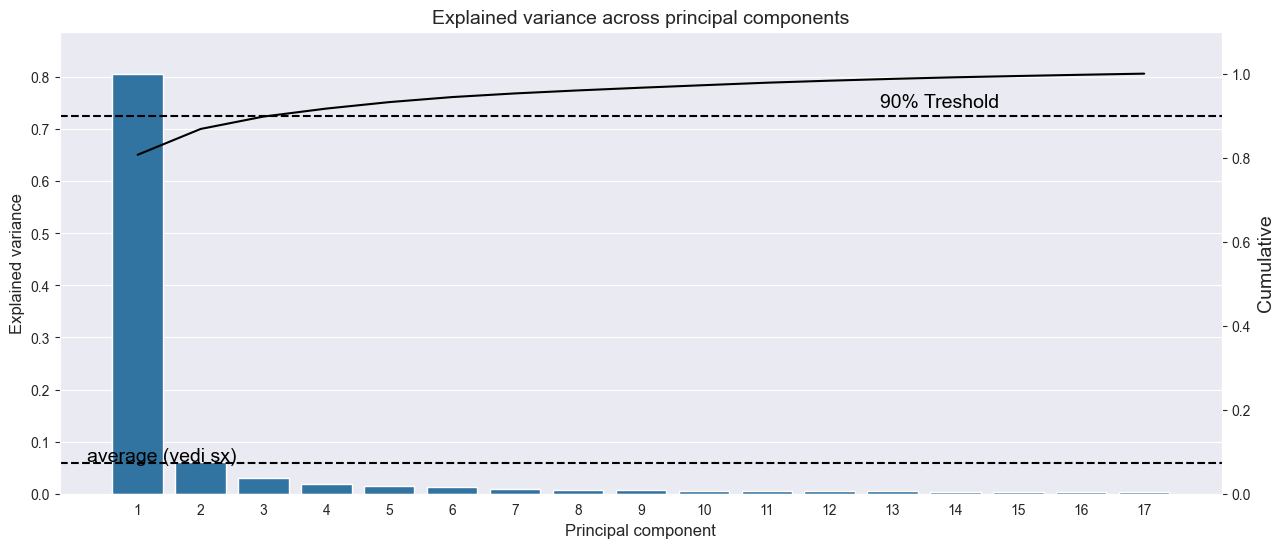

In [34]:
#Scree Plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
custom_palette = sns.color_palette(["#0000FF", "#1E90FF", "#00BFFF", "#4169E1", "#4682B4"])
ax2 = sns.barplot(x=idx, y='Exp Var', data=print_variance,legend=False)
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx-1, y='Cum Var', data=print_variance, color='#000000')
ax1.axhline(mean_variance, ls='--', color='#000000') #plot mean
ax2.axhline(0.90, ls='--', color='#000000') #plot 90%
ax1.text(-.8, mean_variance+(mean_variance*.05), "average (vedi sx)", color='#000000', fontsize=14) #label y axis
ax2.text(11.8, 0.92, "90% Treshold", color='#000000', fontsize=14)
max_y1 = max(print_variance.iloc[:,0])
max_y2 = max(print_variance.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))

La media spiegata dai componenti è: 0.059


Text(0.061764705882352944, 3.2075451544431104, 'Media: 0.06%')

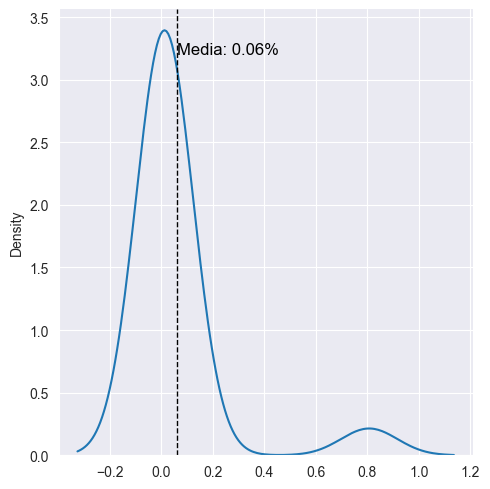

In [35]:
sns.displot(data=explained_variance_ratio,kind='kde')
print(f"La media spiegata dai componenti è: {mean_variance:.3f}")
plt.axvline(x=mean_variance, color='#000000', linestyle='--', linewidth=1, label=f'Mean = {mean_variance:.2f}')
plt.text(mean_variance+(mean_variance*.05), plt.gca().get_ylim()[1] * 0.9,  # Spostamento in x e y
         f'Media: {mean_variance:.2f}%', color='#000000', fontsize=12)

L'average projection error per la KPCA classica sui dati di train: 
[0.83 0.16 0.16 0.09 0.53 0.53 0.43 0.96 0.88 0.95 0.92 0.78 0.59 0.92
 0.66 0.66 0.68]
 ,in termini percentuali, per dati di train: 
[83.   16.   16.    9.   53.12 53.12 42.99 95.58 87.85 94.56 92.01 77.99
 58.97 91.98 65.95 65.95 68.01] con media:63.06,
le performance su dati di test si discostano mediamente del: -2.35


Text(66.21670588235295, 0.012157662591419075, 'Media: 63.06%')

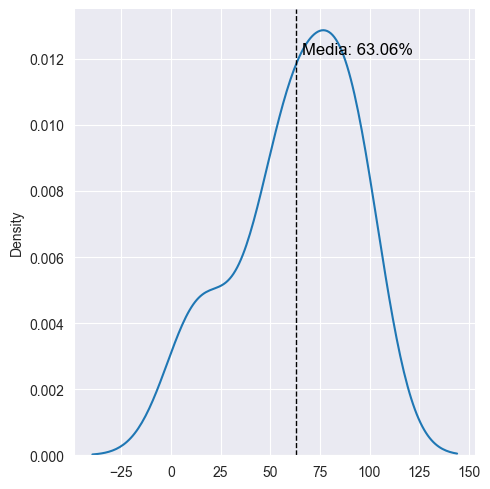

In [37]:
#Sfruttando i dati di Train
kpca_2 = KernelPCA(n_components=4,kernel='poly',fit_inverse_transform=True)
kpca_2.fit(X_train)
data_reduced_train = kpca_2.transform(X_train)
data_original = kpca_2.inverse_transform(data_reduced_train)

#Avg projection error
m = len(X_train)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_train[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_train[i]))**2,2)
avg_proj_error_train = np.round(diff/m,2)
avg_proj_error_train_pct = np.round((avg_proj_error_train/(original_el/m)) * 100,2)
mean_apep_train = np.mean(avg_proj_error_train_pct)

#Sfruttando i dati di test
data_reduced_test = kpca_2.transform(X_test)
data_original = kpca_2.inverse_transform(data_reduced_test)

m = len(X_test)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_test[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_test[i]))**2,2)
avg_proj_error_test = np.round(diff/m,2)
avg_proj_error_test_pct = np.round((avg_proj_error_test/(original_el/m)) * 100,2)
mean_apep_test = np.mean(avg_proj_error_test_pct)

print(f"L'average projection error per la KPCA classica sui dati di train: \n{avg_proj_error_train}\n "
      f",in termini percentuali, per dati di train: \n{avg_proj_error_train_pct} con media:{np.round(mean_apep_train,2)},\n"
      f"le performance su dati di test si discostano mediamente del: {np.round( mean_apep_train - mean_apep_test,2)}")
sns.displot(avg_proj_error_train_pct,kind='kde')
plt.axvline(x=mean_apep_train, color='#000000', linestyle='--', linewidth=1, label=f'Mean = {mean_apep_train:.2f}')
plt.text(mean_apep_train+(mean_apep_train*.05), plt.gca().get_ylim()[1] * 0.9,  # Spostamento in x e y
         f'Media: {mean_apep_train:.2f}%', color='#000000', fontsize=12)

<Axes: >

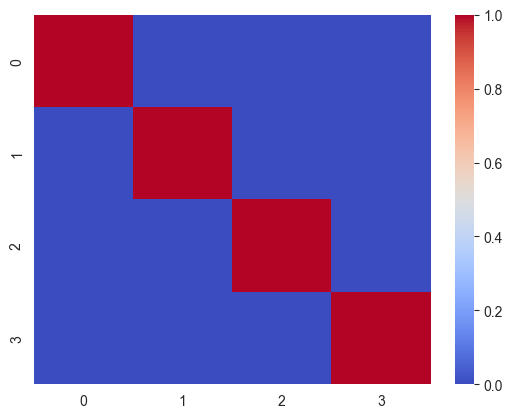

In [38]:
data_pca = kpca_2.transform(X_train)
correlation_matrix = np.corrcoef(data_pca.T)

sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")

In [39]:
device = 'cpu'
X_train = torch.from_numpy(data_reduced_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(data_reduced_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [40]:
#Model Param
hidden_size = 128
input_size = 4
#Inizializziamo il modello, ricorda di runnare prima la cella della rete
model = ModLSTM(input_size=input_size,hidden_size=hidden_size,seq_lenght=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_loss = [] #per Mostrare la loss del modello

In [41]:
t0_kpa = time.time()
for epoch in range(epochs):
    model.train() #Avviso il modello che è in fase di training
    output = model(X_train)
    loss = criterion(output, y_train) #Perchè lstm ci restituisce pure i pesi ma non ce ne facciamo niente
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Valutazione
    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_loss = criterion(test_out, y_test)

        predicted_classes = torch.argmax(test_out, dim=-1)
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=predicted_classes)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f} con Accuracy: {test_acc:.2f}")

t1_kpa = time.time()

Epoch: 9 | Loss: 0.69210| Test loss: 0.69008 con Accuracy: 53.93
Epoch: 19 | Loss: 0.69155| Test loss: 0.69022 con Accuracy: 53.65
Epoch: 29 | Loss: 0.69028| Test loss: 0.68974 con Accuracy: 53.54
Epoch: 39 | Loss: 0.68940| Test loss: 0.69077 con Accuracy: 53.42
Epoch: 49 | Loss: 0.68819| Test loss: 0.68919 con Accuracy: 53.42


In [42]:
print(t1_kpa-t0_kpa)

76.70452117919922


In [43]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/model_kpca_optimal_config.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
model.eval()
model.load_state_dict(torch.load('load/from/path/model_kpca_same_config.pth'))

tensor([1, 1, 1,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0       0.47      0.08      0.14       814
           1       0.54      0.92      0.68       953

    accuracy                           0.53      1767
   macro avg       0.50      0.50      0.41      1767
weighted avg       0.51      0.53      0.43      1767



<Axes: >

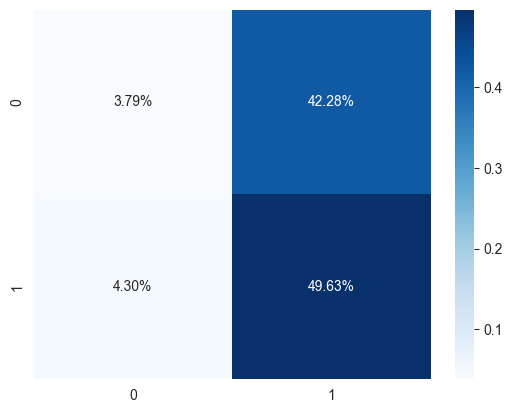

In [44]:
test_output = model(X_test)
predicted_classes = torch.argmax(test_output, dim=-1)
print(predicted_classes)
preds = predicted_classes.cpu().numpy()
y_true = y_test.cpu().numpy()
report = classification_report(y_true, preds)
print(report)
matrix = confusion_matrix(y_true, preds)
sns.heatmap(matrix / np.sum(matrix), annot=True,
            fmt='.2%', cmap='Blues')

## Autoencoders

In [50]:
device = 'cpu'
#X_train = X_train.cpu().numpy()
#X_test = X_test.cpu().numpy()
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)

In [51]:
learning_rate = 0.001
epochs = 50000
latent_dim = 6 #Qui occorre specificare la dim

In [25]:
X_train.shape

torch.Size([7060, 17])

In [52]:
# Model, Loss, Optimizer
model = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []

In [26]:
# Autoencoder Training Loop
for epoch in range(epochs):
    model.train()
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, X_train)
    train_loss.append(loss.item())

     # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        test_out = model(X_test)
        test_loss = criterion(test_out, X_test)


    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f}")


Epoch: 19 | Loss: 1.01792| Test loss: 1.00165
Epoch: 39 | Loss: 1.00514| Test loss: 0.98875
Epoch: 59 | Loss: 0.98780| Test loss: 0.97094
Epoch: 79 | Loss: 0.95784| Test loss: 0.93982
Epoch: 99 | Loss: 0.90561| Test loss: 0.88556
Epoch: 119 | Loss: 0.83779| Test loss: 0.81555
Epoch: 139 | Loss: 0.75692| Test loss: 0.73397
Epoch: 159 | Loss: 0.69376| Test loss: 0.67405
Epoch: 179 | Loss: 0.64689| Test loss: 0.62809
Epoch: 199 | Loss: 0.60849| Test loss: 0.59035
Epoch: 219 | Loss: 0.57287| Test loss: 0.55634
Epoch: 239 | Loss: 0.53643| Test loss: 0.52204
Epoch: 259 | Loss: 0.49836| Test loss: 0.48799
Epoch: 279 | Loss: 0.46716| Test loss: 0.46034
Epoch: 299 | Loss: 0.43561| Test loss: 0.42988
Epoch: 319 | Loss: 0.40849| Test loss: 0.40478
Epoch: 339 | Loss: 0.38288| Test loss: 0.38104
Epoch: 359 | Loss: 0.36015| Test loss: 0.35959
Epoch: 379 | Loss: 0.34215| Test loss: 0.34305
Epoch: 399 | Loss: 0.32913| Test loss: 0.33155
Epoch: 419 | Loss: 0.31919| Test loss: 0.32256
Epoch: 439 | Loss:

In [27]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/autoencode.pth"
torch.save(model.state_dict(), PATH)

In [54]:
model.eval()
model.load_state_dict(torch.load('/Users/francescodesiderato/repos/QuantMath/Model/autoencode.pth'))

/var/folders/r1/yrqdcrd10lxb181crqq08nhr0000gn/T/ipykernel_44365/1451130923.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/fran

<All keys matched successfully>

L'average projection error per la PCA classica sui dati di train: 
[0.05 0.   0.   0.04 0.03 0.03 0.05 0.09 0.03 0.03 0.03 0.08 0.27 0.03
 0.04 0.04 0.04]
 ,in termini percentuali, per dati di train: 
[ 5.    0.    0.    4.    3.01  3.01  4.99  8.98  3.01  3.    3.    8.
 27.    3.    4.    4.    4.  ] con media:5.179999828338623,
le performance su dati di test si discostano mediamente del: 0.36000001430511475


Text(5.435294151306152, 0.08789378490823699, 'Media: 5.18%')

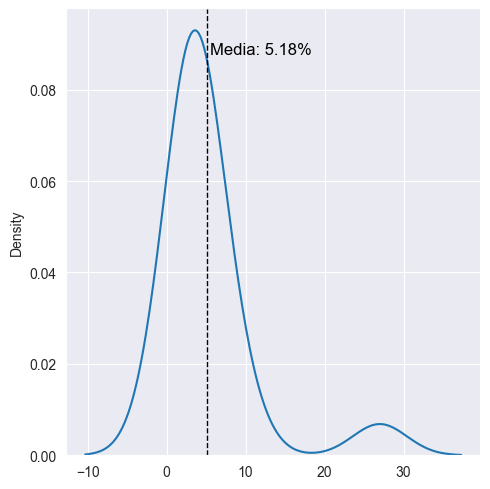

In [56]:
#Dati di Train
data_reduced_train = model.encode(X_train)
data_original = model.decode(data_reduced_train)

data_original = data_original.detach().numpy()
X_test = X_test.cpu().numpy()
X_train = X_train.cpu().numpy()

m = len(X_train)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_train[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_train[i]))**2,2)
avg_proj_error_train = np.round(diff/m,2)
avg_proj_error_train_pct = np.round((avg_proj_error_train/(original_el/m)) * 100,2)
mean_apep_train = np.mean(avg_proj_error_train_pct)

#Sfruttando i dati di test
X_test = torch.from_numpy(X_test).float().to(device)
X_train = torch.from_numpy(X_train).float().to(device)

data_reduced_test = model.encode(X_test)
data_original = model.decode(data_reduced_test)

data_original = data_original.detach().numpy()
X_test = X_test.cpu().numpy()
X_train = X_train.cpu().numpy()

m = len(X_test)
diff = 0
original_el = 0
for i in range(m):
    diff = diff + np.round(np.abs((X_test[i] - data_original[i]))**2,2)
    original_el = original_el + np.round(np.abs((X_test[i]))**2,2)
avg_proj_error_test = np.round(diff/m,2)
avg_proj_error_test_pct = np.round((avg_proj_error_test/(original_el/m)) * 100,2)
mean_apep_test = np.mean(avg_proj_error_test_pct)

print(f"L'average projection error per la PCA classica sui dati di train: \n{avg_proj_error_train}\n "
      f",in termini percentuali, per dati di train: \n{avg_proj_error_train_pct} con media:{np.round(mean_apep_train,2)},\n"
      f"le performance su dati di test si discostano mediamente del: {np.round( mean_apep_train - mean_apep_test,2)}")
sns.displot(avg_proj_error_train_pct,kind='kde')
plt.axvline(x=mean_apep_train, color='#000000', linestyle='--', linewidth=1, label=f'Mean = {mean_apep_train:.2f}')
plt.text(mean_apep_train+(mean_apep_train*.05), plt.gca().get_ylim()[1] * 0.9,  # Spostamento in x e y
         f'Media: {mean_apep_train:.2f}%', color='#000000', fontsize=12)


In [57]:
device = 'cpu'
X_train = torch.from_numpy(X_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)

X_train = model.encode(X_train)
X_train = X_train.detach()
y_train = torch.from_numpy(y_train).long().to(device)
X_test = model.encode(X_test)
X_test = X_test.detach()
y_test = torch.from_numpy(y_test).long().to(device)

In [58]:
#Model Param
hidden_size = 128
input_size = 6
#Inizializziamo il modello
model = ModLSTM(input_size=input_size, hidden_size=hidden_size, seq_lenght=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_loss = []  #per Mostrare la loss del modello

In [59]:
t0_auto = time.time()
for epoch in range(epochs):
    model.train() #Avviso il modello che è in fase di training
    output = model(X_train)
    loss = criterion(output, y_train) #Perchè lstm ci restituisce pure i pesi ma non ce ne facciamo niente
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Valutazione
    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_loss = criterion(test_out, y_test)
        predicted_classes = torch.argmax(test_out, dim=-1)
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=predicted_classes)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f} con Accuracy: {test_acc:.2f}")
t1_auto = time.time()

Epoch: 9 | Loss: 0.69081| Test loss: 0.69318 con Accuracy: 50.82
Epoch: 19 | Loss: 0.68969| Test loss: 0.69438 con Accuracy: 51.05
Epoch: 29 | Loss: 0.68840| Test loss: 0.69506 con Accuracy: 50.54
Epoch: 39 | Loss: 0.68619| Test loss: 0.69830 con Accuracy: 51.05
Epoch: 49 | Loss: 0.68166| Test loss: 0.69940 con Accuracy: 50.25


In [60]:
print(t1_auto-t0_auto)

77.39968991279602


In [33]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/model_autoencode_same_config.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/model_autoencode_same_config.pth"
torch.save(model.state_dict(), PATH)

tensor([0, 1, 1,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0       0.45      0.29      0.35       810
           1       0.54      0.70      0.61       956

    accuracy                           0.51      1766
   macro avg       0.49      0.49      0.48      1766
weighted avg       0.50      0.51      0.49      1766



<Axes: >

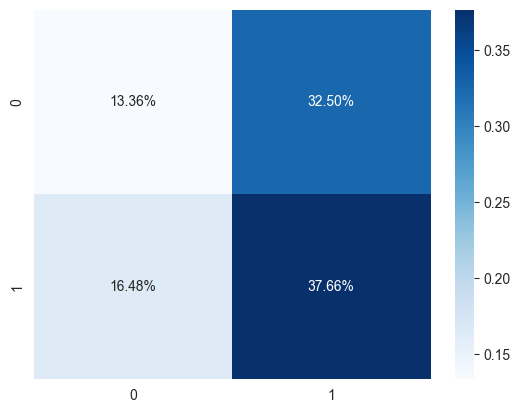

In [40]:
test_output= model(X_test)
predicted_classes = torch.argmax(test_output, dim=-1)
print(predicted_classes)
preds = predicted_classes.cpu().numpy()
y_true = y_test.cpu().numpy()
report = classification_report(y_true, preds)
print(report)
matrix = confusion_matrix(y_true, preds)
sns.heatmap(matrix / np.sum(matrix), annot=True,
            fmt='.2%', cmap='Blues')

## Addestramento della NN

In [28]:
device = 'cpu'
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).long().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).long().to(device)

In [29]:
#Model Param
hidden_size = 128
input_size = 17
#Inizializziamo il modello
model = ModLSTM(input_size=input_size,hidden_size=hidden_size,seq_lenght=2)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_loss = [] #per Mostrare la loss del modello

In [46]:
t0_classic = time.time()
for epoch in range(epochs):
    model.train() #Avviso il modello che è in fase di training
    output = model(X_train)
    loss = criterion(output, y_train) #Perchè lstm ci restituisce pure i pesi ma non ce ne facciamo niente
    train_loss.append(loss.item())
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    # Valutazione
    model.eval()
    with torch.no_grad():
        test_out = model(X_test)
        test_loss = criterion(test_out, y_test)
        predicted_classes = torch.argmax(test_out, dim=-1)
        test_acc = accuracy_fn(y_true=y_test,
                            y_pred=predicted_classes)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}| Test loss: {test_loss:.5f} con Accuracy: {test_acc:.2f}")
t1_classic = time.time()
print(t1_classic - t0_classic)

Epoch: 9 | Loss: 0.68650| Test loss: 0.68861 con Accuracy: 54.05
Epoch: 19 | Loss: 0.68444| Test loss: 0.68936 con Accuracy: 53.71
Epoch: 29 | Loss: 0.68267| Test loss: 0.68606 con Accuracy: 54.95
Epoch: 39 | Loss: 0.67891| Test loss: 0.68235 con Accuracy: 55.97
Epoch: 49 | Loss: 0.67565| Test loss: 0.68165 con Accuracy: 57.05
77.04821515083313


In [61]:
print((t1_classic-t0_classic)-(t1_auto-t0_auto))

-0.3514747619628906


Salvataggio del modello

In [26]:
PATH = "/Users/francescodesiderato/repos/QuantMath/Model/model_seq2.pth"
torch.save(model.state_dict(), PATH)

Load del modello

In [48]:
model.eval()
model.load_state_dict(torch.load('/Users/francescodesiderato/repos/QuantMath/Model/model_seq2.pth'))

/var/folders/r1/yrqdcrd10lxb181crqq08nhr0000gn/T/ipykernel_44365/4075013783.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/fran

RuntimeError: Error(s) in loading state_dict for ModLSTM:
	size mismatch for lstm.weight_ih_l0: copying a param with shape torch.Size([512, 17]) from checkpoint, the shape in current model is torch.Size([512, 4]).

In [28]:
test_output= model(X_test)
predicted_classes = torch.argmax(test_output, dim=-1)
print(predicted_classes)

tensor([1, 1, 1,  ..., 1, 1, 1])


In [29]:
preds = predicted_classes.cpu().numpy()
y_true = y_test.cpu().numpy()

              precision    recall  f1-score   support

           0       0.58      0.44      0.50       809
           1       0.60      0.73      0.66       956

    accuracy                           0.59      1765
   macro avg       0.59      0.58      0.58      1765
weighted avg       0.59      0.59      0.59      1765



<Axes: >

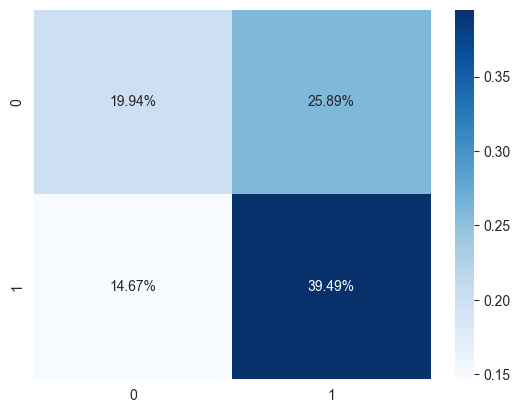

In [30]:
report = classification_report(y_true, preds)
print(report)
matrix = confusion_matrix(y_true, preds)
sns.heatmap(matrix/np.sum(matrix), annot=True,
            fmt='.2%', cmap='Blues')